<a href="https://colab.research.google.com/github/bofeng2268/qm2/blob/main/random_routes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install geopandas
!pip install plotly
!pip install tabulate

In [67]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from statsmodels.formula.api import ols
import geopandas as gpd
import requests
import json
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col


# **Generating random coordinates for start points of routes to Royal London Hospital**

---



In [ ]:
import random

# function to generated a list of 100 random coordinates to use as starting points for routes to Royal London Hospital
def generate_random_coordinates(num_points, central_lat_lon, greater_lat_lon):
    random_coords = []
    while len(random_coords) < num_points:
        lat = random.uniform(greater_lat_lon['min_lat'], greater_lat_lon['max_lat'])
        lon = random.uniform(greater_lat_lon['min_lon'], greater_lat_lon['max_lon'])

        if central_lat_lon['min_lat'] <= lat <= central_lat_lon['max_lat'] and central_lat_lon['min_lon'] <= lon <= central_lat_lon['max_lon']:
            continue
        random_coords.append((lat, lon))

    return random_coords

# defined the boundary coordinates for Central London and Greater London
central_london = {'min_lat': 51.44, 'max_lat': 51.56, 'min_lon': -0.18, 'max_lon': 0.02}
greater_london = {'min_lat': 51.38, 'max_lat': 51.60, 'min_lon': -0.33, 'max_lon': 0.15}

# generated list using function
random_coordinates = generate_random_coordinates(100, central_london, greater_london)

# **Plotting starting points (blue) and destination (red)**

In [ ]:
import geopandas as gpd
import plotly.express as px
import pandas as pd

# loading London topojson
london_shapefile = gpd.read_file('https://gist.githubusercontent.com/cejast/2cb80a2346b2049ac5d0/raw/c7ea98c7b9204782b6652b29bf3ef3e3b1a187ea/london-topojson.json')

# extracting latitude and longitude from the list of coordinates
latitudes, longitudes = zip(*random_coordinates)

# creating a datframe with extracted coordinates
df = pd.DataFrame({'Latitude': latitudes, 'Longitude': longitudes})

# creating a scatterplot on a Mapbox
fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude',
                        hover_name='Latitude', hover_data=['Longitude'],
                        title='Random Coordinates on Greater London Map',
                        mapbox_style="carto-positron",
                        center={"lat": 51.5074, "lon": -0.1278},
                        zoom=10)

fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})

# creating a dataframe for the Royal London Hospital coordinates
hospital_df = pd.DataFrame({
    'Latitude': [51.517327],
    'Longitude': [-0.059259]
})

# adding the hospital location as a separate scatter plot layer
fig.add_trace(
    px.scatter_mapbox(hospital_df, lat='Latitude', lon='Longitude',
                      color_discrete_sequence=['red']).data[0]
)

fig.show()


# **Perform requests to Tfl API to get duration and number of transport changes for journeys from each different start point (for both disabled and non-disabled peole) and store them in a dataframe**

---



In [ ]:
import requests
import json
import pandas as pd
import random
from tabulate import tabulate

#function to parse json responses of TFL API requests
def parse_journey_data(journey_data):
    if 'journeys' not in journey_data or not journey_data['journeys']: # requests had some missing data depending on the routes, so checking and giving None output when necessary
        return None, None

    shortest_duration = min(journey_data['journeys'], key=lambda x: x['duration'])['duration'] #finding minimum duration
    shortest_journey = next(j for j in journey_data['journeys'] if j['duration'] == shortest_duration) #finds journey that has thee shortest duration that we previously found
    transport_changes = len(shortest_journey['legs']) #number of times one has to change transport during journey called "legs"

    return shortest_duration, transport_changes

# dataframe to store journey data for disabled and non-disabled people for each route
journey_data_df = pd.DataFrame(columns=['Start Coordinate', 'Disabled Duration', 'Disabled Changes',
                                        'Non-Disabled Duration', 'Non-Disabled Changes'])

api_key = 'd963cc094f604b6bbb599c4602b8d3a7' #could also import it from private file, but is fine as i used it only for the purpose of this code, not confidential

for start_point in random_coordinates:

    start_point = f"{start_point[0]}, {start_point[1]}"  #respective random points coordinates
    end_point = '51.517327, -0.059259'  #Royal London Hospital coordinates
    url = f'https://api.tfl.gov.uk/Journey/JourneyResults/{start_point}/to/{end_point}'

    headers = {
        'app_key': api_key,
    }

    # request parameters for a disabled person with full step-free access and only using tube
    params_disabled = {
        'accessibilityPreference': 'StepFreeToVehicle,StepFreeToPlatform',
        'mode': 'tube'
    }

    # request parameters for a non-disabled person using only tube
    params_non_disabled = {
        'mode': 'tube'
    }

    response_disabled = requests.get(url, headers=headers, params=params_disabled)
    journey_disabled = response_disabled.json()

    response_non_disabled = requests.get(url, headers=headers, params=params_non_disabled)
    journey_non_disabled = response_non_disabled.json()

    shortest_duration_disabled, transport_changes_disabled = parse_journey_data(journey_disabled)# disabled journey data (duration and trasport changes)
    shortest_duration_non_disabled, transport_changes_non_disabled = parse_journey_data(journey_non_disabled) # non-disabled journey data (duration and trasport changes)

    new_row = pd.DataFrame([{
    'Start Coordinate': start_point,
    'Disabled Duration': shortest_duration_disabled,
    'Disabled Changes': transport_changes_disabled,
    'Non-Disabled Duration': shortest_duration_non_disabled,
    'Non-Disabled Changes': transport_changes_non_disabled
    }])
    journey_data_df = pd.concat([journey_data_df, new_row], ignore_index=True) #adding new row with respective columns for each jouney to the dataframe

journey_data_df = journey_data_df.dropna() # dropping rows that have None values


In [51]:
# converting all columns except coordinates to numeric, because if converted them to NaN
for column in journey_data_df.columns:
    if column != 'Start Coordinate':
        journey_data_df[column] = pd.to_numeric(journey_data_df[column], errors='coerce')

journey_data_df

,Start Coordinate,Disabled Duration,Disabled Changes,Non-Disabled Duration,Non-Disabled Changes
1,"51.39350931144743, -0.22775204117425796",121,4,94,5
3,"51.55034257266594, 0.09318587473067008",60,3,57,3
6,"51.434043992902545, -0.1976123503433892",77,3,59,3
10,"51.580068310718175, 0.0996317936585282",141,6,52,4
13,"51.556565736459284, -0.24699084494840834",98,4,59,4
14,"51.426073613099476, -0.19611561025125396",77,3,72,5
16,"51.56016026548028, 0.0935130483719096",78,3,69,4
17,"51.41890262664958, -0.22569258564727715",86,3,83,3
18,"51.587164263400645, -0.06837874652276427",70,4,57,4
25,"51.56138433118701, -0.3293574262518458",88,4,83,4


# **Summary Statistics**

In [52]:
journey_no_coordinates = journey_data_df.drop(columns=['Start Coordinate']) #as they are not numberical values, they can be excluded
summary = journey_no_coordinates.describe().round(2)
summary = summary.T
summary



,count,mean,std,min,25%,50%,75%,max
Disabled Duration,49.0,87.57,19.48,43.0,75.0,87.0,97.0,141.0
Disabled Changes,49.0,3.49,0.74,1.0,3.0,3.0,4.0,6.0
Non-Disabled Duration,49.0,71.59,16.96,41.0,59.0,70.0,79.0,122.0
Non-Disabled Changes,49.0,3.88,0.83,3.0,3.0,4.0,4.0,6.0


from the summary statistics we can see that the mean of the duration of journeys for diabled people is already higher

# **Filter Outliers**

In [53]:
def filter_outliers(var):
    Q1 = var.quantile(0.25)  # Calculate the first quartile
    Q3 = var.quantile(0.75)  # Calculate the third quartile
    IQR = Q3 - Q1  # Calculate the interquartile range
    LOWBOUND = Q1 - 3*IQR  # Calculate the lower bound
    HIGHBOUND = Q3 + 3*IQR  # Calculate the upper bound

    # Get the indices of the rows that are within the bounds
    valid_indices = var[(var > LOWBOUND) & (var < HIGHBOUND)].index

    # Filter the DataFrame using the valid indices
    filtered = journey_no_coordinates.loc[valid_indices]

    dropped_observations = len(var) - len(filtered)  # Calculate the number of observations that were dropped
    print('Dropped {} observations'.format(dropped_observations))

    return filtered, valid_indices

In [57]:

journeys_data_no_outliers,_ = filter_outliers(journey_no_coordinates['Disabled Duration'])
journeys_data_no_outliers,_ = filter_outliers(journeys_data_no_outliers['Non-Disabled Duration'])
journeys_data_no_outliers,_ = filter_outliers(journeys_data_no_outliers['Disabled Changes'])
journeys_data_no_outliers,_ = filter_outliers(journeys_data_no_outliers['Non-Disabled Changes'])


Dropped 0 observations
Dropped 0 observations
Dropped 0 observations
Dropped 0 observations


# **Boxplots and Analysis**

---



### **Duration of journey:**

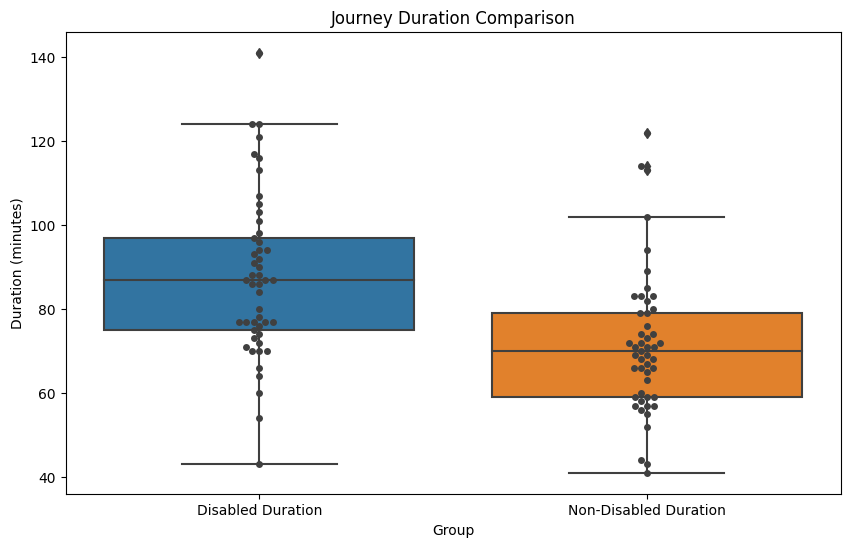

T-statistic: 4.33
P-value: 4e-05


In [89]:
disabled_duration = journeys_data_no_outliers['Disabled Duration']
non_disabled_duration = journeys_data_no_outliers['Non-Disabled Duration']

#boxplots
plt.figure(figsize=(10, 6))

sns.boxplot(x='Group', y='Duration', data=pd.melt(journeys_data_no_outliers[['Disabled Duration', 'Non-Disabled Duration']], var_name='Group', value_name='Duration'))
sns.swarmplot(x='Group', y='Duration', data=pd.melt(journeys_data_no_outliers[['Disabled Duration', 'Non-Disabled Duration']], var_name='Group', value_name='Duration'), color=".25")

plt.title('Journey Duration Comparison')
plt.xlabel('Group')
plt.ylabel('Duration (minutes)')
plt.show()

# Statistical Test
t_stat, p_value = stats.ttest_ind(disabled_duration, non_disabled_duration, equal_var=False)

print(f"T-statistic: {t_stat.round(2)}")
print(f"P-value: {p_value.round(5)}")


We have strong evidence to reject the null hypothesis as the T-statistic is of 4.33 and the P-value < 0.001. Tthere is a significant difference in journey durations between disabled and non-disabled individuals, the positive T-statistic indicating that, on average, disabled people tend to have higher journey durations compared to non-disabled people.
There is a statistically significant difference in journey durations between disabled and non-disabled individuals, and the evidence shows that disabled people tend to have higher journey durations.


In [90]:
disabled_mean = journey_data_df['Disabled Duration'].mean()
non_disabled_mean = journey_data_df['Non-Disabled Duration'].mean()

# calculating percentage difference
percentage_difference = ((disabled_mean - non_disabled_mean) / non_disabled_mean) * 100
print(f"On average, disabled people's journey durations are {percentage_difference.round(2)}% higher than non-disabled people.")


On average, disabled people's journey durations are 22.32% higher than non-disabled people.


### **Number of transport changes**:

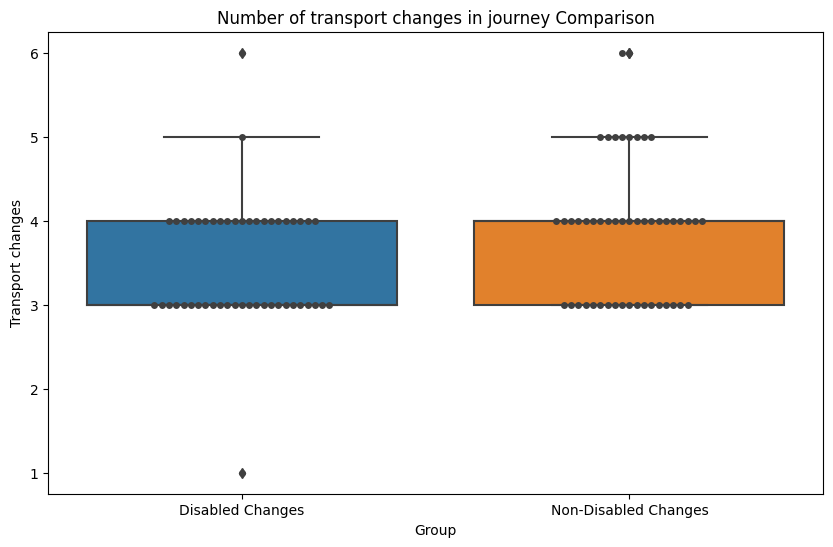

T-statistic: -2.44
P-value: 0.01665


In [91]:
disabled_transport_changes = journeys_data_no_outliers['Disabled Changes']
non_disabled_transport_changes = journeys_data_no_outliers['Non-Disabled Changes']

plt.figure(figsize=(10, 6))

sns.boxplot(x='Group', y='Duration', data=pd.melt(journeys_data_no_outliers[['Disabled Changes', 'Non-Disabled Changes']], var_name='Group', value_name='Duration'))
sns.swarmplot(x='Group', y='Duration', data=pd.melt(journeys_data_no_outliers[['Disabled Changes', 'Non-Disabled Changes']], var_name='Group', value_name='Duration'), color=".25")

plt.title('Number of transport changes in journey Comparison')
plt.xlabel('Group')
plt.ylabel('Transport changes')
plt.show()

# Statistical Test
t_stat, p_value = stats.ttest_ind(disabled_transport_changes, non_disabled_transport_changes, equal_var=False)

print(f"T-statistic: {t_stat.round(2)}")
print(f"P-value: {p_value.round(5)}")

The negative t-statistic indicates that, on average, disabled people have fewer transport changes compared to non-disabled people and the p-value suggests that this difference is statistically significant. Therefore there is a significant difference in the number of transport changes between disabled and non-disabled people, with the former likely experiencing fewer changes on their journeys. This might be due to the fact that fewer stations are accessible, therefore there are less options, and less transport changes to be done to optimise journey time (journeys are longer for disabled people on average, as we have seen above). However this is only one of the possible explanations and there is no certain relationship of causality.